In [1]:
import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Ignore FutureWarning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

D:\software\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
true_data = pd.read_csv("../../DataSet/fake-and-real-news-dataset/True.csv")
false_data = pd.read_csv("../../DataSet/fake-and-real-news-dataset/Fake.csv")

In [3]:
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# label the data
true_data['target'] = 1
false_data['target'] = 0

In [5]:
# use sample
df = pd.concat([false_data,true_data]).sample(frac=1).reset_index(drop=True)

Text(0.5, 1.0, 'Target Dist.')

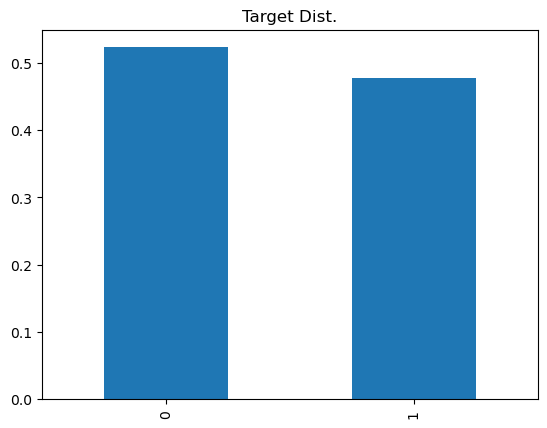

In [6]:
# check distribution
df.target.value_counts(normalize=True).plot(kind='bar')
plt.title('Target Dist.')

In [7]:
# EDA
# check duplication
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

209
0


In [8]:
# check NA
df.isna().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

In [9]:
# feature engineering
X = df[['title', 'text', 'subject']]
y = df[['target']]

In [10]:
# filter 
def wp(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    text = re.sub(" reuters ","",text)
    text = re.sub("  "," ",text)

    return text

X['text'] = X['text'].apply(lambda x:wp(x))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_83640\2980867795.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = X['text'].apply(lambda x:wp(x))


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((35751, 3), (8938, 3), (35751, 1), (8938, 1))

In [56]:
from scipy.sparse import hstack

vectorizer1 = TfidfVectorizer()
XV_train_title = vectorizer1.fit_transform(X_train['title'])
XV_test_title = vectorizer1.transform(X_test['title'])
feature_names_title = ['title_' + f for f in vectorizer1.get_feature_names_out()]

vectorizer2 = TfidfVectorizer()
XV_train_text = vectorizer2.fit_transform(X_train['text'])
XV_test_text = vectorizer2.transform(X_test['text'])
feature_names_text = ['text_' + f for f in vectorizer2.get_feature_names_out()]

vectorizer3 = TfidfVectorizer()
XV_train_subject = vectorizer3.fit_transform(X_train['subject'])
XV_test_subject = vectorizer3.transform(X_test['subject'])
feature_names_subject = ['subject_' + f for f in vectorizer3.get_feature_names_out()]

tfidf_combined = hstack((XV_train_title, XV_train_text, XV_train_subject))
X_train = pd.DataFrame.sparse.from_spmatrix(
    tfidf_combined, 
    columns=feature_names_title + feature_names_text + feature_names_subject,
    index=X_train.index
)


tfidf_combined_test = hstack((XV_test_title, XV_test_text, XV_test_subject))
X_test = pd.DataFrame.sparse.from_spmatrix(
    tfidf_combined_test, 
    columns=feature_names_title + feature_names_text + feature_names_subject,
    index=X_test.index
)
print(X_train.shape, X_test.shape)

(35751, 117839) (8938, 117839)


In [40]:
score_baseline = y.value_counts(normalize=True).max()
score_baseline

0.5253641835798518

In [42]:
# train the model
model = LogisticRegression(n_jobs=-1)
model.fit(X_train,y_train)

D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(n_jobs=-1)

In [44]:
# result
pred=model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4710
           1       1.00      1.00      1.00      4228

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



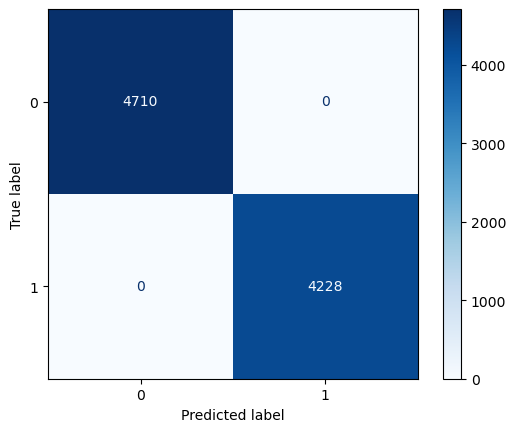

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, pred,cmap='Blues')

In [60]:
# for example, can select feature before
classes_names={1:"True",0:"Fake"}
def output_lable(n):
    return f'This text is {classes_names[n]}'
    
def manual_testing(news):
    news["text"] = news["text"].apply(wp) 
    news_title = vectorizer1.transform(news['title'])
    news_text = vectorizer2.transform(news['text'])
    news_subject = vectorizer1.transform(news['subject'])
    # news_test = pd.concat([news_title, news_text, news_subject], axis=1)
    news_tfidf_combined = hstack((news_title, news_text, news_subject))
    news_test = pd.DataFrame.sparse.from_spmatrix(
        news_tfidf_combined, 
        # columns=feature_names_title + feature_names_text + feature_names_subject,
        # index=X_train.index
    )
    pred_lr = model.predict(news_test)
    print(f'{output_lable(pred_lr[0])}')
    
true_string = true_data.sample(frac=1).head(1).drop(columns=['target', 'date'], axis=1)
false_string = false_data.sample(frac=1).head(1).drop(columns=['target', 'date'], axis=1)

print(true_string)
manual_testing(false_string)
# manual_testing(true_string)

                                                  title  \
1748  Factbox: Trump on Twitter (September 13) - Tax...   

                                                   text       subject  
1748  The following statements were posted to the ve...  politicsNews  


D:\software\anaconda\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


ValueError: X has 137403 features, but LogisticRegression is expecting 117839 features as input.